# Notebook - Modélisation

## Kaggle Challenge: House Prices - Advanced Regression Techniques

In [138]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.linear_model import Lasso, LassoCV, RidgeCV, Ridge
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [164]:
train_data = pd.read_csv('new_train.csv')
Xtrain = pd.read_csv('new_train.csv')

In [165]:
train_data.set_index('Id', inplace=True)
Xtrain.set_index('Id', inplace=True)

**Data processing**

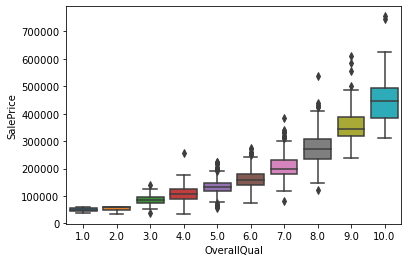

In [144]:
sns.boxplot(x='OverallQual', y='SalePrice', data=Xtrain)
plt.show()

In [166]:
Target = np.log1p(Xtrain.SalePrice)
X = Xtrain.drop(['SalePrice'], axis=1)

OverallQual = X['OverallQual']
X_train, X_val, y_train, y_val = train_test_split(X, Target,
                                                  random_state=42,
                                                  test_size=0.25,
                                                  stratify=OverallQual)

In [167]:
# Stratifie KFold
index_train = X_train.index

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold = skf.split(X_train, OverallQual[index_train])

In [168]:
quant_feats = [x for x in X.columns if X[x].nunique() > 2]

scaler = RobustScaler()

X_train[quant_feats] = scaler.fit_transform(X_train[quant_feats])
X_val[quant_feats] = scaler.transform(X_val[quant_feats])

C:\Users\linaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\linaj\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\linaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

### Régression linéaire

**Ridge**

In [169]:
n_alphas = 500
alphas = np.logspace(-2, 8, n_alphas)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append(1-r2_score(y_val,ridge.predict(X_val)))

12:35: E231 missing whitespace after ','


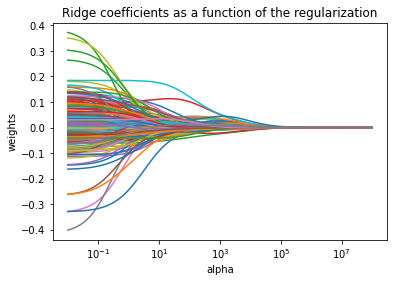

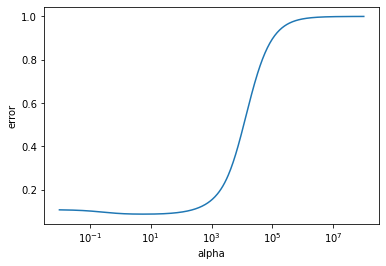

In [170]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [172]:
print('minimum error : ', min(errors))
alpha = alphas[errors.index(min(errors))]
print('best alpha : ', alpha)

best_ridge = Ridge(alpha).fit(X_train, y_train)
rg_pred = best_ridge.predict(X_val)

rg_rmse = np.sqrt(mean_squared_error(y_val, rg_pred))
rg_r2 = r2_score(y_val, rg_pred)

print("RMSE : {:.4f}".format(rg_rmse))
print("R2 : {:.3f}".format(rg_r2))

minimum error :  0.08702760664071041
best alpha :  5.828154581230846
RMSE : 0.1194
R2 : 0.913


**Elastic Net**

In [173]:
fold = skf.split(X_train, OverallQual[index_train]) 

n_alphas = 800
alphas = np.logspace(-5, 2, n_alphas)

elascv = ElasticNetCV(alphas=alphas, n_alphas=n_alphas,
                      cv=fold, random_state=1).fit(X_train, y_train)

print("Best alpha : ", elascv.alpha_)


C:\Users\linaj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
1:52: W291 trailing whitespace
10:1: W391 blank line at end of file


Best alpha :  0.0010778061958577486


In [174]:
alpha = elascv.alpha_
elas = ElasticNet(alpha=alpha).fit(X_train, y_train)
elas_pred = elas.predict(X_val)

elas_rmse = np.sqrt(mean_squared_error(y_val, elas_pred))
elas_r2 = r2_score(y_val, elas_pred)

print("RMSE : {:.4f}".format(elas_rmse))
print("R2 : {:.3f}".format(elas_r2))

RMSE : 0.1178
R2 : 0.915


### Random Forest

In [41]:
fold = skf.split(X_train, OverallQual[index_train]) 

param_grid = {
    'n_estimators' : [100, 500, 1000, 1500, 2000],
    'max_depth' : [10, 50, 100, 150, 200]
}

start_time = timeit.default_timer()

rfr = RandomForestRegressor()
rf_gs = GridSearchCV(estimator=rfr, param_grid=param_grid,
                     cv=fold)
rf_gs.fit(X_train, y_train)

elapsed = timeit.default_timer() - start_time
print("time {:.2f}s".format(elapsed))
print(rf_gs.best_params_)

C:\Users\linaj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


time 864.64s
{'max_depth': 150, 'n_estimators': 1000}


KeyError: 'min_samples_leaf'

RMSE : 0.1372
R2 : 0.8852


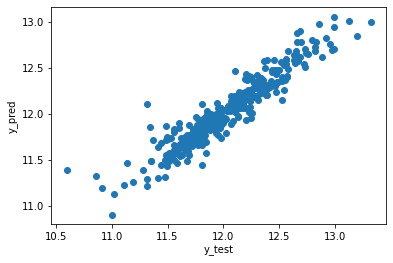

In [175]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=150,
                           min_samples_leaf=2, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
rf_r2 = r2_score(y_val, rf_pred)

print("RMSE : {:.4f}".format(rf_rmse))
print("R2 : {:.4f}".format(rf_r2))

plt.scatter(y_val, rf_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### Gradient Boosting

In [92]:
fold = skf.split(X_train, OverallQual[index_train]) 

param_grid = {
    'n_estimators' : [500, 1000, 2000, 4000, 6000, 8000],
    'learning_rate': [1, 0.1, 0.01, 0.001],
    'max_depth' : [2, 4, 6, 8]
}

gbr = GradientBoostingRegressor()

gbr_gs = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=fold)
gbr_gs.fit(X_train, y_train)

print(gbr_gs.best_params_)

C:\Users\linaj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}


RMSE : 0.1231
R2 0.9075


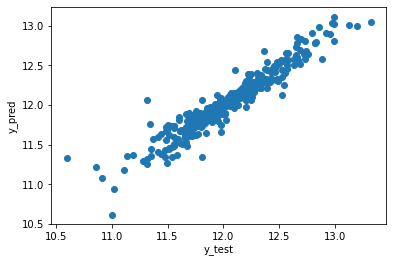

In [177]:
start_time = timeit.default_timer()

gbr = GradientBoostingRegressor(n_estimators=3500, learning_rate=0.01,
                                max_depth=2, random_state=42)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, gbr_pred))
r2 = r2_score(y_val, gbr_pred)

print("RMSE : {:.4f}".format(rmse))
print("R2 {:.4f}".format(r2))

plt.scatter(y_val, gbr_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### LGBM Regressor

In [167]:
fold = skf.split(X_train, OverallQual[index_train]) 

param_grid = {
    'n_estimators' : [500, 1000, 2000, 3000, 4000, 5000],
    'learning_rate': [1,0.1, 0.01, 0.001],
    'num_leaves': np.arange(3, 50, 5)}
    

lgm = LGBMRegressor(objective='regression')

lgm_gs = GridSearchCV(estimator=lgm, param_grid=param_grid, cv=fold)
lgm_gs.fit(X_train, y_train)

print(lgm_gs.best_params_)

C:\Users\linaj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'learning_rate': 0.01, 'n_estimators': 4000, 'num_leaves': 7}


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
RMSE : 0.1232
R2 0.907


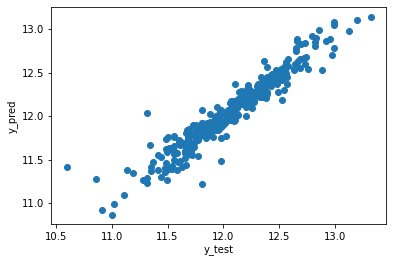

In [179]:
start_time = timeit.default_timer()

# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', num_leaves=6,
                         learning_rate=0.01, n_estimators=3500,
                         max_bin=200, bagging_fraction=0.75,
                         bagging_freq=5, bagging_seed=7, feature_fraction=0.2,
                         feature_fraction_seed=7, verbose=-1, random_state=42)

lightgbm.fit(X_train, y_train)
lgbm_pred = lightgbm.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, lgbm_pred))
r2 = r2_score(y_val, lgbm_pred)

print("RMSE : {:.4f}".format(rmse))
print("R2 {:.3f}".format(r2))

plt.scatter(y_val, lgbm_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### XGBoost

In [204]:
fold = skf.split(X_train, OverallQual[index_train]) 

param_grid = {
    'n_estimators' : [1000, 2000, 3000, 4000, 5000],
    'learning_rate' : [0.05, 0.01, 0.005],
    'max_depth' : [2, 3, 5, 7, 9],
    'min_child_weight' : [1, 2, 3, 4, 5, 6]
}
    

xgbr = XGBRegressor(objective='reg:squarederror')

xgb_gs = GridSearchCV(estimator=xgbr, param_grid=param_grid,
                      cv=fold, n_jobs = -1, verbose = 1)
xgb_gs.fit(X_train, y_train)

print(xgb_gs.best_params_)

C:\Users\linaj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 50.5min finished


NameError: name 'xgbr_gs' is not defined

RMSE : 0.1183
R2 0.915


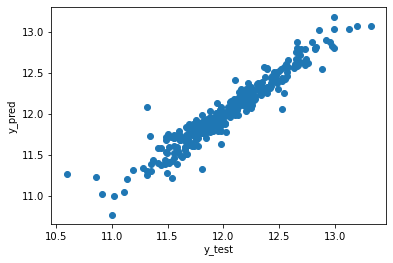

In [181]:
start_time = timeit.default_timer()

xgb = XGBRegressor(learning_rate=0.01, n_estimators=3300, max_depth=2,
                   min_child_weight=4, gamma=0, subsample=0.7,
                   colsample_bytree=0.7, objective='reg:squarederror',
                   nthread=-1, scale_pos_weight=1,
                   seed=27, reg_alpha=0.00005, random_sate=0)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)


rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
r2 = r2_score(y_val, xgb_pred)

print("RMSE : {:.4f}".format(rmse))
print("R2 {:.3f}".format(r2))

plt.scatter(y_val, xgb_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### PMC Regressor

In [182]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(160, ), solver="adam",
                   max_iter=500, activation='logistic', random_state=1)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_val)

mlp_rmse = np.sqrt(mean_squared_error(y_val, mlp_pred))
mlp_r2 = r2_score(y_val, mlp_pred)

print("RMSE : {:.4f}".format(mlp_rmse))
print("R2 : {:.4f}".format(mlp_r2))

RMSE : 0.1798
R2 : 0.8026


###   Prédiction

In [107]:
Xtest = pd.read_csv('new_test.csv')

Xtest.set_index('Id',inplace=True)
X_test = Xtest.copy()

X_test[quant_feats] = scaler.transform(X_test[quant_feats])

In [137]:
# submission score
y_pred = elas.predict(X_test)

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': np.expm1(y_pred)})
output.to_csv('prediction.csv', index=False)

RMSE : 0.4068
R2 : -19.417


### Cross Validation

In [113]:
from sklearn.model_selection import cross_validate

def cross_results(results): 
    mean_r2 = results['test_r2'].mean()
    std_r2 = results['test_r2'].std()
    mean_rmse = np.sqrt(-results['test_neg_mean_squared_error']).mean()
    std_rmse = np.sqrt(-results['test_neg_mean_squared_error']).std()
    mean_fit_time = results['fit_time'].mean()
    return pd.DataFrame(np.array([mean_rmse,mean_r2,std_r2,mean_fit_time]),
                        index=['RMSE','R2','R2 Standard Deviations','Fit time']).round(3)

def display_cross_results(results): 
    
    print("R2 Scores:",results['test_r2'].round(5)) 
    print("Mean Test Scores:",results['test_r2'].mean().round(5)) 
    print("Std Test Scores:",results['test_r2'].std().round(5)) 
    print("Mean Fit time", results['fit_time'].mean().round(5))

In [114]:
fold = skf.split(X, OverallQual) 

elas_results = cross_validate(elas, X, Target, cv=5,scoring=['r2','neg_mean_squared_error']) 

cross_results(elas_results)

,0
RMSE,0.117
R2,0.913
R2 Standard Deviations,0.005
Fit time,0.037


In [115]:
gbr_results = cross_validate(gbr, X, Target, cv=5,scoring=['r2','neg_mean_squared_error']) 

cross_results(gbr_results)

,0
RMSE,0.125
R2,0.901
R2 Standard Deviations,0.013
Fit time,2.086


In [116]:
xgb_results = cross_validate(xgb, X, Target, cv=5,scoring=['r2','neg_mean_squared_error']) 

cross_results(xgb_results)

,0
RMSE,0.124
R2,0.903
R2 Standard Deviations,0.011
Fit time,9.932
